<a href="https://colab.research.google.com/github/PranavNG/Machine-Learning/blob/main/Covid_Dectection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download Dataset from DropBox or Kaggle or any other source.

In [2]:
!wget https://www.dropbox.com/s/z90tdkbgljrdvcv/DataSet_CovidXRay.zip
!unzip "/content/DataSet_CovidXRay.zip"
!rm "/content/DataSet_CovidXRay.zip"

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating:

In [4]:
import pandas as pd
import numpy as np
import os
import shutil
import glob
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import vgg16
from keras.models import Model
from keras.layers import Dense, MaxPool2D, Conv2D
import keras
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten , Dense, Dropout , MaxPool2D
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


# Go through Meta-Data

In [16]:
covid_imgs = pd.read_excel("./COVID-19_Radiography_Dataset/COVID.metadata.xlsx")
covid_imgs.head(5)

,FILE NAME,FORMAT,SIZE,URL
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...
4,COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...


In [17]:
opacity_imgs = pd.read_excel("./COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx")
opacity_imgs.head(5)

,FILE NAME,FORMAT,SIZE,URL
0,Lung_Opacity-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,Lung_Opacity-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,Lung_Opacity-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,Lung_Opacity-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,Lung_Opacity-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [18]:
normal_imgs = pd.read_excel("./COVID-19_Radiography_Dataset/Normal.metadata.xlsx")
normal_imgs.head(5)

,FILE NAME,FORMAT,SIZE,URL
0,NORMAL-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,NORMAL-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,NORMAL-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,NORMAL-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,NORMAL-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [19]:
pneumonia_images = pd.read_excel("./COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx")
pneumonia_images.head(5)

,FILE NAME,FORMAT,SIZE,URL
0,Viral Pneumonia-1,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
1,Viral Pneumonia-2,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
2,Viral Pneumonia-3,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
3,Viral Pneumonia-4,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...
4,Viral Pneumonia-5,PNG,256*256,https://www.kaggle.com/paultimothymooney/chest...


#Creating image folders.

In [20]:
root_dir = "/content/COVID-19_Radiography_Dataset/"
imgs = ['COVID','Lung_Opacity','Normal','Viral Pneumonia']

new_dir = "/content/all_images/"

In [21]:
if not os.path.exists(new_dir):
  os.mkdir(new_dir)

  for i in imgs:
    org_dir = os.path.join(root_dir, i+"/")
    
    for imgfile in glob.iglob(os.path.join(org_dir, "*.png")):
      shutil.copy(imgfile, new_dir)
      
else:
  print("Already Exist")


Already Exist


In [22]:
c = {'COVID':0,'Lung_Opacity':0,'Normal':0,'Viral Pneumonia':0}

for image in imgs:
  for count in glob.iglob(new_dir + image+"*"):
    c[image] += 1

c

{'COVID': 8, 'Lung_Opacity': 6012, 'Normal': 5492, 'Viral Pneumonia': 45}

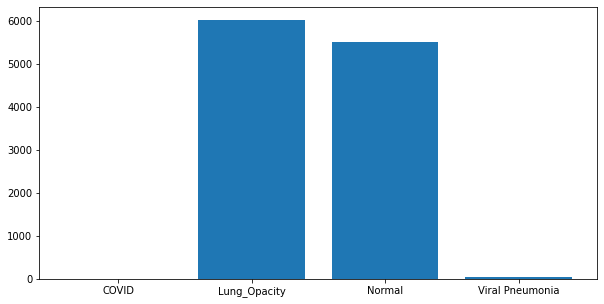

In [23]:
plt.figure(figsize=(10,5))
plt.bar(x = c.keys(), height= c.values())
plt.show()

In [24]:
if not os.path.exists(new_dir+"train_test_split/"):

  os.makedirs(new_dir+"train_test_split/")

  os.makedirs(new_dir+"train_test_split/train/Normal")
  os.makedirs(new_dir+"train_test_split/train/Covid")

  os.makedirs(new_dir+"train_test_split/test/Normal")
  os.makedirs(new_dir+"train_test_split/test/Covid")

  os.makedirs(new_dir+"train_test_split/validation/Normal")
  os.makedirs(new_dir+"train_test_split/validation/Covid")


  # Train Data
  for i in np.random.choice(replace= False , size= 3000 , a = glob.glob(new_dir+imgs[0]+"*") ):
    shutil.copy(i , new_dir+"train_test_split/train/Covid" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 3900 , a = glob.glob(new_dir+imgs[2]+"*") ):
    shutil.copy(i , new_dir+"train_test_split/train/Normal" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 900 , a = glob.glob(new_dir+imgs[3]+"*") ):
    shutil.copy(i , new_dir+"train_test_split/train/Covid" )
    os.remove(i)

  # Validation Data
  for i in np.random.choice(replace= False , size= 308 , a = glob.glob(new_dir+imgs[0]+"*") ):
    shutil.copy(i , new_dir+"train_test_split/validation/Covid" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 500 , a = glob.glob(new_dir+imgs[2]+"*") ):
    shutil.copy(i , new_dir+"train_test_split/validation/Normal" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 200 , a = glob.glob(new_dir+imgs[3]+"*") ):
    shutil.copy(i , new_dir+"train_test_split/validation/Covid" )
    os.remove(i)

  # Test Data
  for i in np.random.choice(replace= False , size= 300 , a = glob.glob(new_dir+imgs[0]+"*") ):
    shutil.copy(i , new_dir+"train_test_split/test/Covid" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 300 , a = glob.glob(new_dir+imgs[2]+"*") ):
    shutil.copy(i , new_dir+"train_test_split/test/Normal" )
    os.remove(i)

  for i in np.random.choice(replace= False , size= 200 , a = glob.glob(new_dir+imgs[3]+"*") ):
    shutil.copy(i , new_dir+"train_test_split/test/Covid" )
    os.remove(i)

In [25]:
train_path  = "/content/all_images/train_test_split/train"
valid_path  = "/content/all_images/train_test_split/validation"
test_path   = "/content/all_images/train_test_split/test"

In [26]:
train_data_gen = ImageDataGenerator(preprocessing_function= vgg16.preprocess_input , zoom_range= 0.2, horizontal_flip= True, shear_range= 0.2 , rescale= 1./255)
train = train_data_gen.flow_from_directory(directory= train_path , target_size=(224,224))

Found 7800 images belonging to 2 classes.


In [27]:
validation_data_gen = ImageDataGenerator(preprocessing_function= vgg16.preprocess_input , rescale= 1./255 )
valid = validation_data_gen.flow_from_directory(directory= valid_path , target_size=(224,224))

Found 1008 images belonging to 2 classes.


In [28]:
test_data_gen = ImageDataGenerator(preprocessing_function= vgg16.preprocess_input, rescale= 1./255 )
test = train_data_gen.flow_from_directory(directory= test_path , target_size=(224,224), shuffle= False)

Found 800 images belonging to 2 classes.


In [29]:
train.class_indices

{'Covid': 0, 'Normal': 1}

In [30]:
class_type = {0:'Covid',  1 : 'Normal'}
t_img , label = train.next()

In [31]:
def plotImages(img_arr, label):

  for im, l in zip(img_arr,label) :
    plt.figure(figsize= (5,5))
    plt.imshow(im, cmap = 'gray')
    plt.title(im.shape)
    plt.axis = False
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


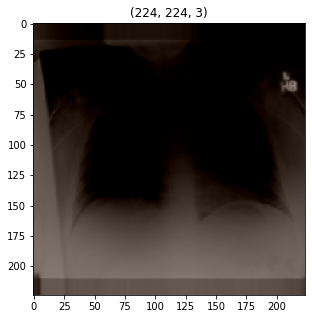

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


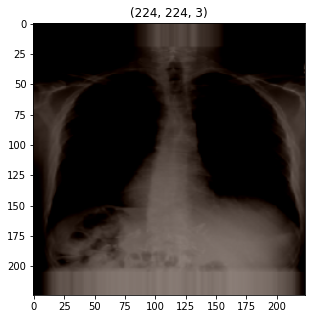

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


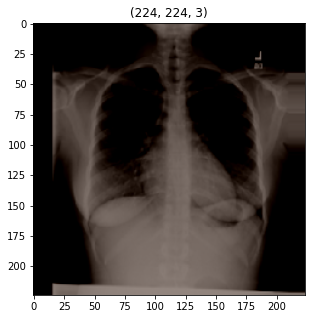

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


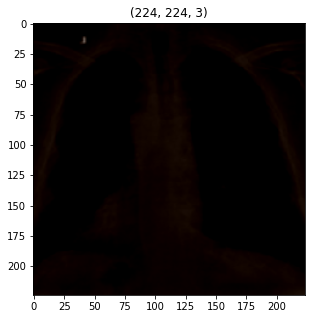

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


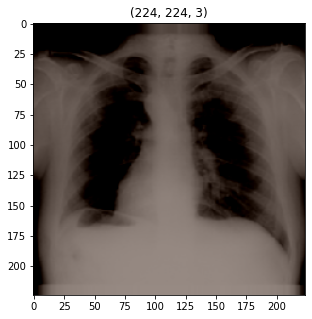

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


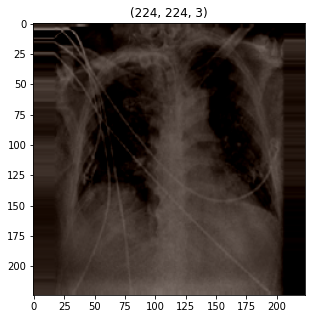

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


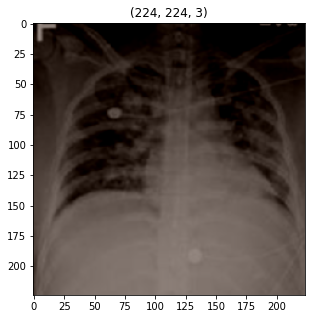

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


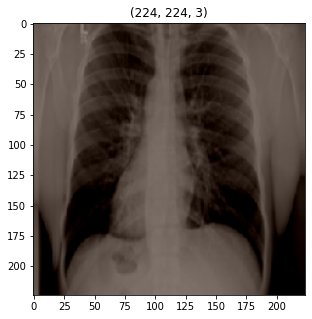

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


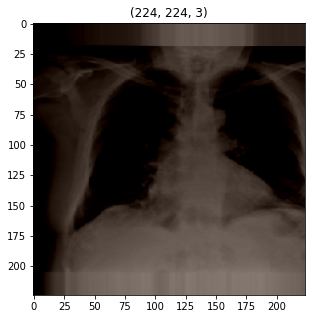

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


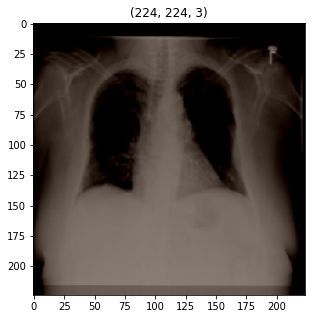

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


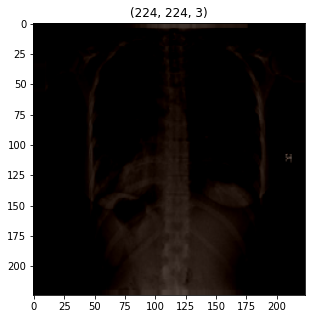

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


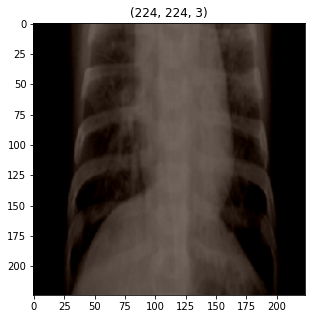

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


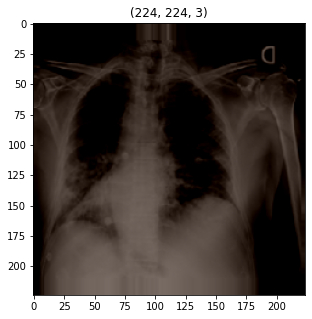

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


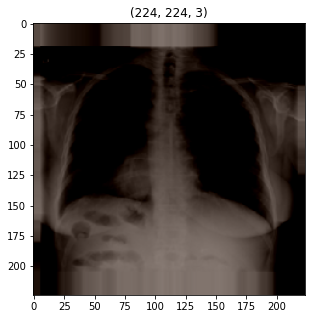

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


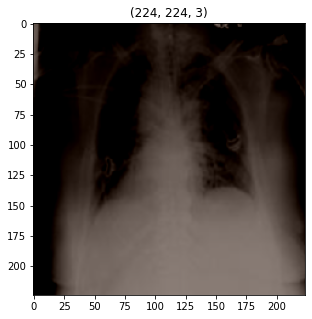

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


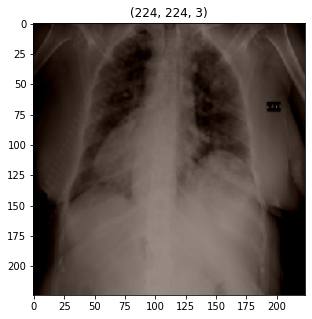

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


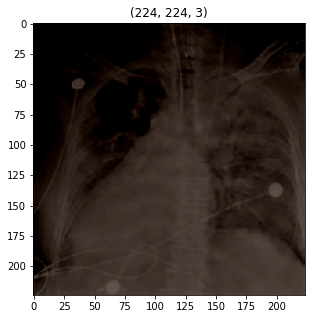

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


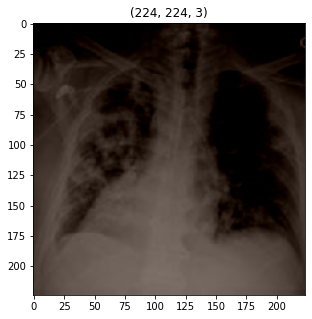

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


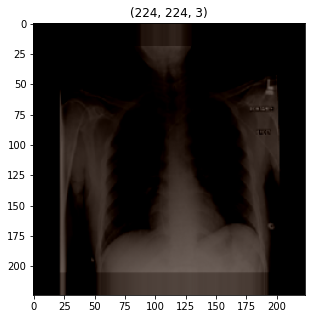

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


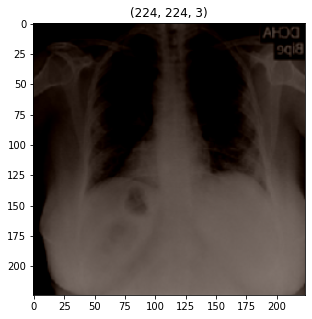

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


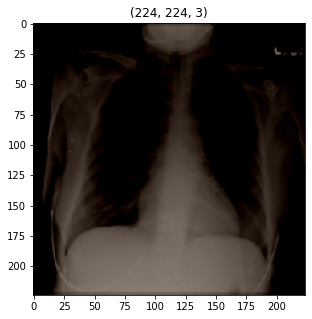

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


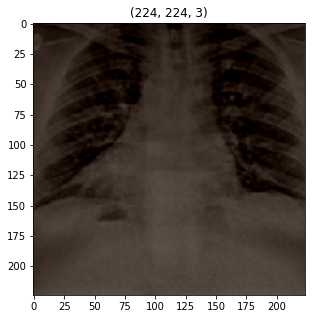

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


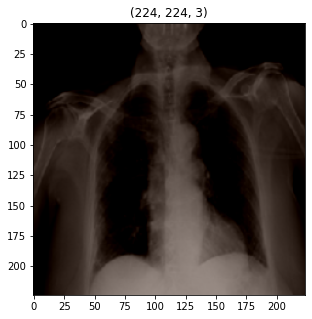

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


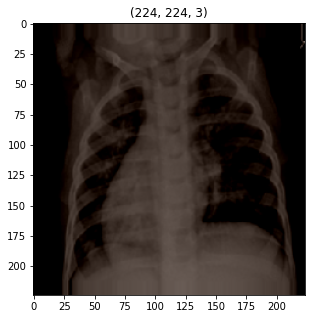

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


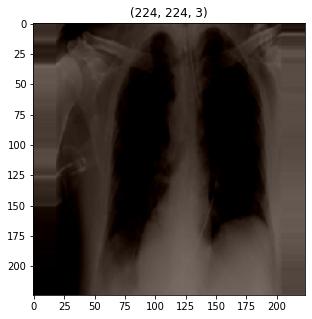

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


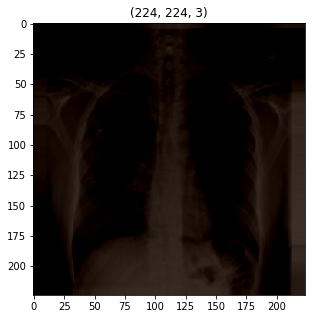

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


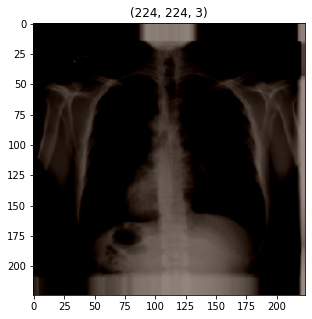

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


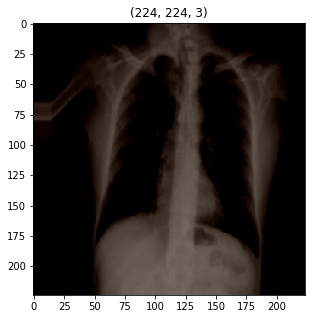

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


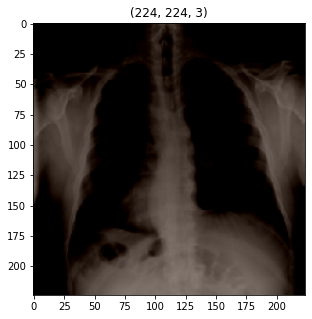

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


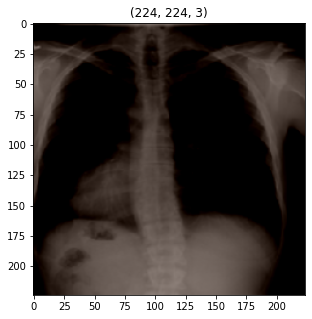

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


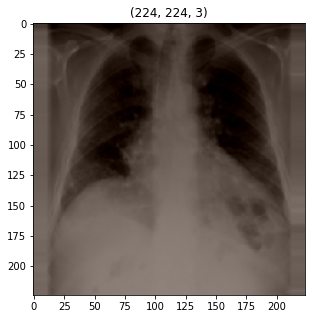

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


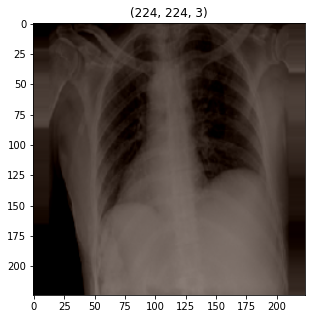

In [32]:
plotImages(t_img, label)

In [10]:
vgg = VGG16( input_shape=(224,224,3), include_top= False) 

In [11]:
for layer in vgg.layers:           # Dont Train the parameters again 
  layer.trainable = False

In [12]:
x = Flatten()(vgg.output)
x = Dense(units=2 , activation='sigmoid', name = 'predictions' )(x)

model = Model(vgg.input, x)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])


In [6]:
es = EarlyStopping(monitor= "val_accuracy" , min_delta= 0.01, patience= 3, verbose=1)
mc = ModelCheckpoint(filepath="bestmodel.h5", monitor="val_accuracy", verbose=1, save_best_only= True)

In [36]:
hist = model.fit_generator(train, steps_per_epoch= 10, epochs= 10, validation_data= valid , validation_steps= 32, callbacks=[es,mc])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 0.6245 - accuracy: 0.7281 
Epoch 1: val_accuracy improved from -inf to 0.84226, saving model to bestmodel.h5
10/10 [==============================] - 665s 72s/step - loss: 0.6245 - accuracy: 0.7281 - val_loss: 0.3551 - val_accuracy: 0.8423
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.3771 - accuracy: 0.8469 
Epoch 2: val_accuracy did not improve from 0.84226
10/10 [==============================] - 664s 72s/step - loss: 0.3771 - accuracy: 0.8469 - val_loss: 0.4260 - val_accuracy: 0.8105
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.4642 - accuracy: 0.7969 
Epoch 3: val_accuracy did not improve from 0.84226
10/10 [==============================] - 664s 72s/step - loss: 0.4642 - accuracy: 0.7969 - val_loss: 0.5514 - val_accuracy: 0.7550
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.4120 - accuracy: 0.8250 
Epoch 4: val_accuracy did not improve from 

In [37]:
from keras.models import load_model
model = load_model("bestmodel.h5")

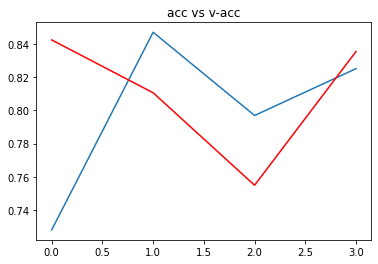

In [39]:
h = hist.history
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'] , c = "red")
plt.title("acc vs v-acc")
plt.show()


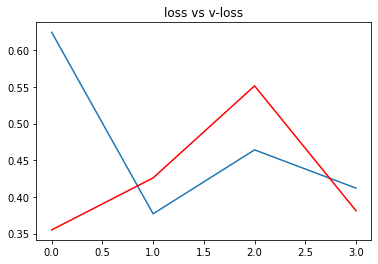

In [40]:
plt.plot(h['loss'])
plt.plot(h['val_loss'] , c = "red")
plt.title("loss vs v-loss")
plt.show()

In [41]:
acc = model.evaluate_generator(generator= test)[1] 

print(f"The accuracy of your model is = {acc} %")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


The accuracy of your model is = 0.8324999809265137 %


In [42]:
from keras.preprocessing import image

def get_img_array(img_path):
  """
  Input : Takes in image path as input 
  Output : Gives out Pre-Processed image
  """
  path = img_path
  img = image.load_img(path, target_size=(224,224,3))
  img = image.img_to_array(img)/255
  img = np.expand_dims(img , axis= 0 )
  
  return img

The given X-Ray image is of type = Normal

The chances of image being Covid is : 49.40452575683594 percent

The chances of image being Normal is : 58.85927677154541 percent


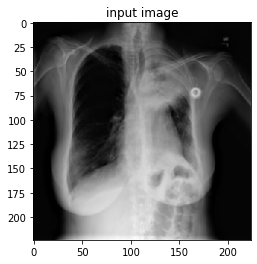

In [45]:
path = "/content/all_images/Lung_Opacity-1890.png"       # you can add any image path

#predictions: path:- provide any image from google or provide image from all image folder
img = get_img_array(path)

res = class_type[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type = {res}")
print()
print(f"The chances of image being Covid is : {model.predict(img)[0][0]*100} percent")
print()
print(f"The chances of image being Normal is : {model.predict(img)[0][1]*100} percent")

# to display the image  
plt.imshow(img[0], cmap = "gray")
plt.title("input image")
plt.show()